
# Eksplorativna analiza podataka za projekt 'Detekcija raka na temelju histoloških preparata'


**Bjanka Bašić, Ivan Knezić i Jelena Lončar**

travanj 2019.

## Opis podataka

Odabran je dataset s web stranice Kaggle. Radi se o skupu podataka koji je verzija PatchCamelyon (PCam) benchmark skupa podataka, dostupnog na sljedećem
linku: https://github.com/basveeling/pcam, samo što su maknuti svi duplikati. U odabranom datasetu se nalazi 220025 primjera za treniranje i 57458 primjera za testiranje.

Podaci koje koristimo sastoje se od velikog broja malih fotografija koje treba klasificirati,
kao i od datoteke koja sadrži stvarne vrijednosti ciljne varijable za pojedine primjere iz train skupa.
Fotografije u skupu podataka dimenzija su 96 x 96px, a ono što rješavanje ovog problema čini
osobito izazovnim jest to što metastaze mogu biti reda veličine jedne stanice usred velikog područja
tkiva. Određen se primjer smatra pozitivnim primjerom ako centralno područje fotografije
dimenzija 32 x 32px sadrži barem jedan piksel tumorskog tkiva. Tumorsko tkivo u okolnom
području fotografije ne utječe na vrijednost ciljne varijable.

In [41]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

data = pd.read_csv('train_labels.csv')
train_path = '../projekt/train/'
test_path = '../projekt/test/'

data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

## Omjer negativnih i pozitivnih primjera

In [91]:
def ra(a, b):
    a = float(a)
    b = float(b)
    if b == 0:
        return a
    return ra(b, a % b)

def get_ratio(a, b):
    r = ra(a, b)
    return "%.2f" % float((a/r) / (b/r))

def ratio(a, b):
    return "%.f / %.f" % (float(a)/(a+b)*100, float(b)/(a+b)*100)

In [92]:
get_ratio(130908, 89117), ratio(130908, 89117)

('1.47', '59 / 41')

Primjetimo da je negativnih primjera skoro 1.5 puta više od pozitivnih tj. preciznije **omjer negativnih/pozitivnih je 59/41**. To je dovoljno dobra ravnoteža da bi mogli izgraditi dobar model sa ovim podacima.

## Izgled primjera u skupu podataka

Prikazati ćemo po 4 primjera snimki preparata bez i sa tumorskim tkivom:

In [93]:
def readImage(path):
    bgr_img = cv2.imread(path)
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return bgr_img

In [94]:
bgr_img = cv2.imread('../projekt/train/0000da768d06b879e5754c43e2298ce48726f722.tif')
cv2.imshow('bgr_img',bgr_img)

Text(0.5, 0.98, 'Histološki preparati tkiva limfnih čvorova ')

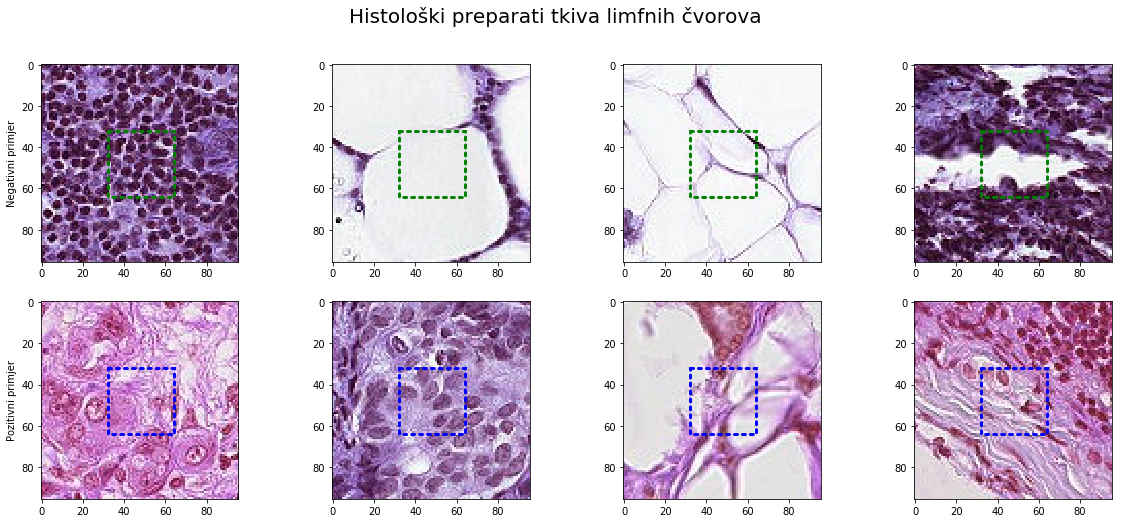

In [95]:
shuffled_data = shuffle(data) #slučajni odabir podataka koji ćemo prikazati

fig, ax = plt.subplots(2,4, figsize=(20,8))

# Negativni primjeri
for i, id_slike in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:4]):
    path = os.path.join(train_path, id_slike)
    ax[0,i].imshow(readImage(path + '.tif'))

    box = patches.Rectangle((32,32),32,32,linewidth=3,edgecolor='green',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negativni primjer')

# Pozitivni primjeri
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:4]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImage(path + '.tif'))

    box = patches.Rectangle((32,32),32,32,linewidth=3,edgecolor='blue',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Pozitivni primjer')

fig.suptitle('Histološki preparati tkiva limfnih čvorova ',fontsize=20)

Ovako golom oku je teško primjetiti što bi točno bilo tumorno tkivo, no bitno da možemo napraviti model koji može.

## Statistička analiza primjera

Želimo vidjeti koja je srednja vrijednost i standardna devijacija za svaki kanal boje. To ćemo izračunati tako da za svaku sliku izračunamo srednje vrijednosti i onda sumu tih vrijednosti podijelimo sa brojem slika (primjera) - dobivamo $m$. Standardnu derivaciju ćemo izračunati po formuli:
$$s = \sqrt{\sum_{i=1}^n \dfrac{x_i^2}{n} - m^2}$$
gdje je n ukupan broj slika (primjera).

In [64]:
def readImage2(path):
    bgr_img = cv2.imread(path)
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return bgr_img / 255

In [65]:
taman_pixel = 10 / 255
svijetli_pixel = 245 / 255
pretamne_slike = []
presvijetle_slike = []

x_tot = np.zeros(3)
x2_tot = np.zeros(3)
ukupno = 0

for i, id_slike in tqdm_notebook(enumerate(shuffled_data['id']), 'computing statistics...(220025 it total)'):
    path = os.path.join(train_path, id_slike)
    rgb_slika = readImage2(path + '.tif').reshape(-1,3)
    #pretamne i presvijetle slike ne želimo u statistici pa ih zapišemo i nastavljamo
    if(rgb_slika.max() < taman_pixel):
        pretamne_slike.append(id_slike)

    if(rgb_slika.min() > svijetli_pixel):
        presvijetle_slike.append(id_slike)
        continue
    
    x_tot += rgb_slika.mean(axis=0)
    x2_tot += (rgb_slika**2).mean(axis=0)
    ukupno += 1

In [66]:
channel_avr = x_tot/ukupno
channel_std = np.sqrt(x2_tot/ukupno - channel_avr**2)
channel_avr, channel_std

(array([0.69645017, 0.54624074, 0.70244388]),
 array([0.21625519, 0.28209607, 0.2388974 ]))

### Odbacivanje outliera

Tijekom računanja srednje vrijednosti i standardne devijacije spremali smo primjere koji su bili pretamni i presvijetli. Prikažimo ih da vidimo o čemu se radi:

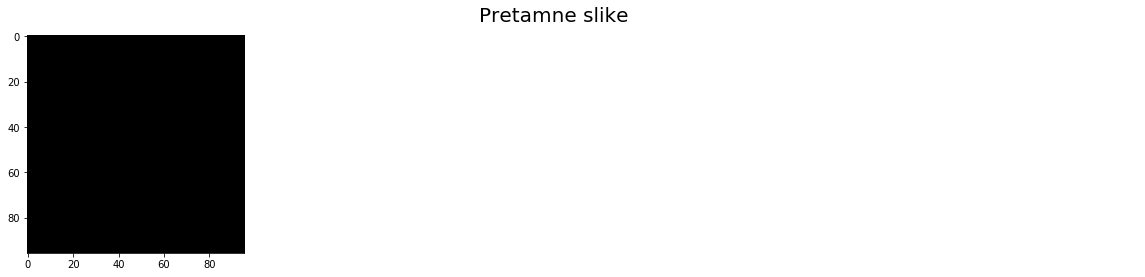

In [88]:
#Tamni primjeri
br_t = min(4, len(pretamne_slike))
fig, ax = plt.subplots(1,4,figsize=(20,4))
fig.suptitle('Pretamne slike',fontsize=20)

for i, id_slike in enumerate(pretamne_slike[:br_t]):
    labl = shuffled_data[shuffled_data['id'] == id_slike]['label']
    path = os.path.join(train_path, id_slike)
    ax[i].imshow(readImage2(path + '.tif'))

for i in range(br_t,4):
    ax[i].axis('off')

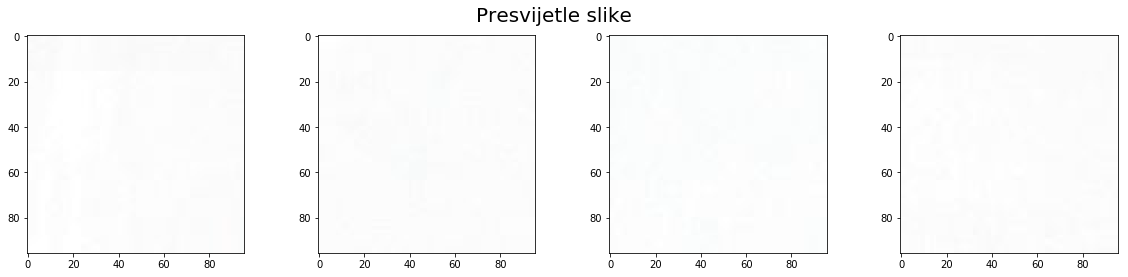

In [90]:
#Svijetli primjeri
br_s = min(4, len(presvijetle_slike))
fig, ax = plt.subplots(1,4,figsize=(20,4))
fig.suptitle('Presvijetle slike',fontsize=20)

for i, id_slike in enumerate(presvijetle_slike[:br_s]):
    labl = shuffled_data[shuffled_data['id'] == id_slike]['label']
    path = os.path.join(train_path, id_slike)
    ax[i].imshow(readImage2(path + '.tif'))

for i in range(br_s,4):
    ax[i].axis('off')

In [85]:
print("Ukupno takvih primjera je:", len(pretamne_slike)+len(presvijetle_slike))

Ukupno takvih primjera je: 7


Broj takvih primjera je 7 što je zanemarivo s obzirom na sveukupan broj train primjera pa neće nikako utjecati na rezultat.